# Secondary Placer 2.0
My idea for this is that it we will use this semi-hierarchically. I will find the best fit values for the x-y parameters initially using this script and then use these as absolute values in the main run. I've got a plan to make this quick!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

In [2]:
galaxy = 'Arp256'

In [3]:
folder = 'C:/Users/oryan/Documents/PySPAM_Original_Python_MCMC'

In [4]:
obs_image = np.load(f'{folder}/APySPAM_MCMC/All_Inputs/{galaxy}.npy')

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


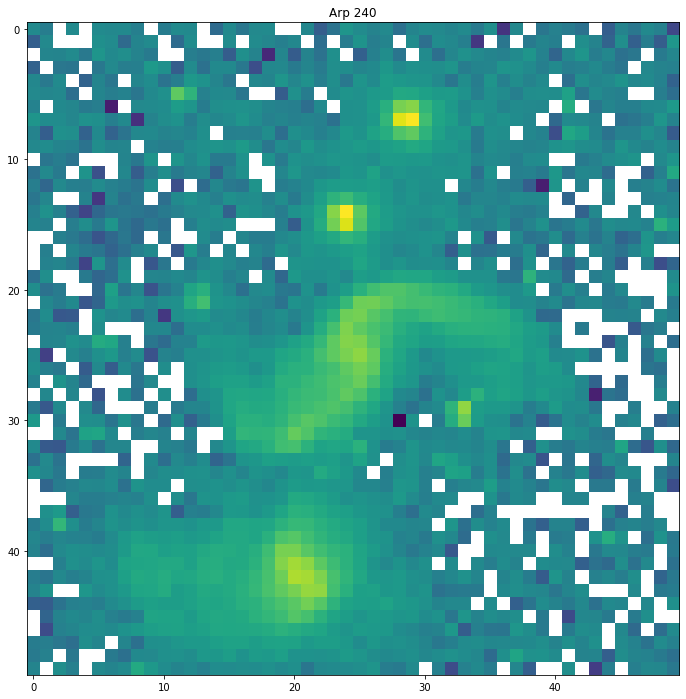

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(obs_image))
plt.title('Arp 240')
plt.show()

In [6]:
def Sigma_Calc(Input_Image):    
    # Artificial Cleaning of Input 
    input_image = Input_Image.copy()
    input_image[input_image <= 0] = np.min(abs(input_image))
    factor = 1e-28
    input_image = input_image/factor
    sigma_image = np.sqrt(input_image)
    sigma_image[sigma_image == 0] = np.min(sigma_image[sigma_image > 0])
    sigma_image_exp = (sigma_image * factor).astype('float64')
    
    return sigma_image_exp

In [7]:
sigma = Sigma_Calc(obs_image)

In [8]:
centre = int(obs_image.shape[0]/2)

In [9]:
centre

25

In [10]:
prim_centre = obs_image[centre - 3: centre + 3, centre - 3: centre + 3]

## Comparing Cutouts

In [11]:
def pixel_like_calc(im, sig, centre):
    pix_likelihood = np.zeros([im.shape[0],im.shape[1]])
    for i in range(im.shape[0]):       
        for j in range(im.shape[1]):
            x_up_lim = i + 3
            x_low_lim = i - 3
            y_up_lim = j + 3
            y_low_lim = j - 3
            
            if x_low_lim < 0:
                x_low_lim = 0
            if x_up_lim >= im.shape[0]:
                x_up_lim = im.shape[0]
            if y_low_lim < 0:
                y_low_lim = 0
            if y_up_lim > im.shape[1]:
                y_up_lim = im.shape[1]
                
            im_area = im[y_low_lim:y_up_lim,x_low_lim:x_up_lim]
            sig_area = sig[y_low_lim:y_up_lim,x_low_lim:x_up_lim]
            centre_area = centre[:im_area.shape[0], :im_area.shape[1]]
            N = im_area.shape[0] * im_area.shape[1]
                
            pix_likelihood[i,j] = (1/N) * np.sum((im_area - centre_area) ** 2 / (2*(sig_area) ** 2))
    return pix_likelihood
            

In [12]:
likelihood_dist = pixel_like_calc(obs_image, sigma, prim_centre)

In [13]:
likelihood_dist

array([[639848.75051597, 543788.5608694 , 435096.02564385, ...,
         69366.3668168 , 232155.46617449, 485291.93099965],
       [547200.02736923, 459686.01959639, 481113.92420229, ...,
         53932.35996891, 176008.78342982, 365481.34316842],
       [492200.94585811, 472163.57463492, 468658.39754281, ...,
         73700.20633098, 221498.58482244, 377096.58292204],
       ...,
       [200686.86942064, 285834.52322347, 228781.24223021, ...,
        195415.64101565,  64368.83951162, 136887.56784526],
       [334358.58991103, 290143.0511054 , 232499.07488838, ...,
        290891.78117072, 285821.36827664,  99849.7965226 ],
       [ 78444.54360375,  70584.23896305,  57468.70786145, ...,
        308921.06102982, 225552.57533235,   5416.3287703 ]])

In [14]:
likelihood_dist_min = likelihood_dist.copy()
likelihood_dist_min[22:28,22:28] = 1e30

In [15]:
y, x = np.where(likelihood_dist_min == np.min(likelihood_dist_min))

In [16]:
print(y)
print(x)

[21]
[43]


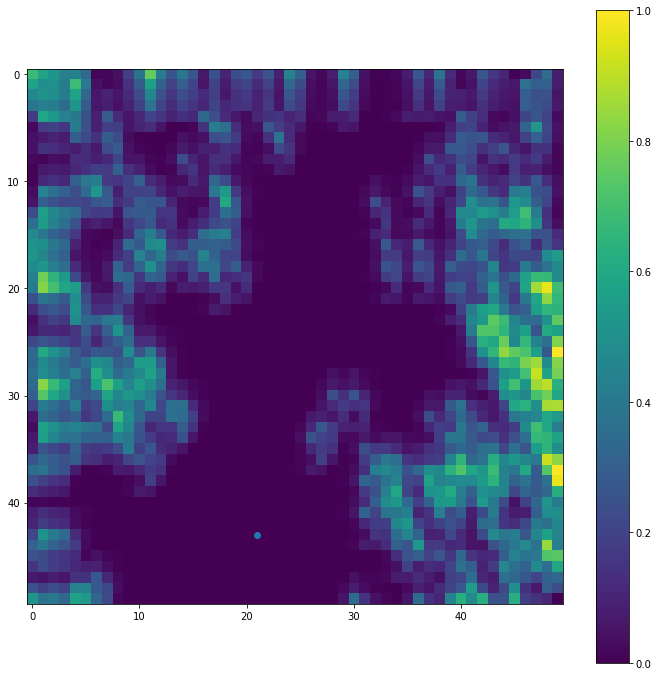

In [17]:
plt.figure(figsize=(12,12))
plt.imshow(likelihood_dist.T)
plt.scatter(y,x)
plt.colorbar()
plt.show()

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


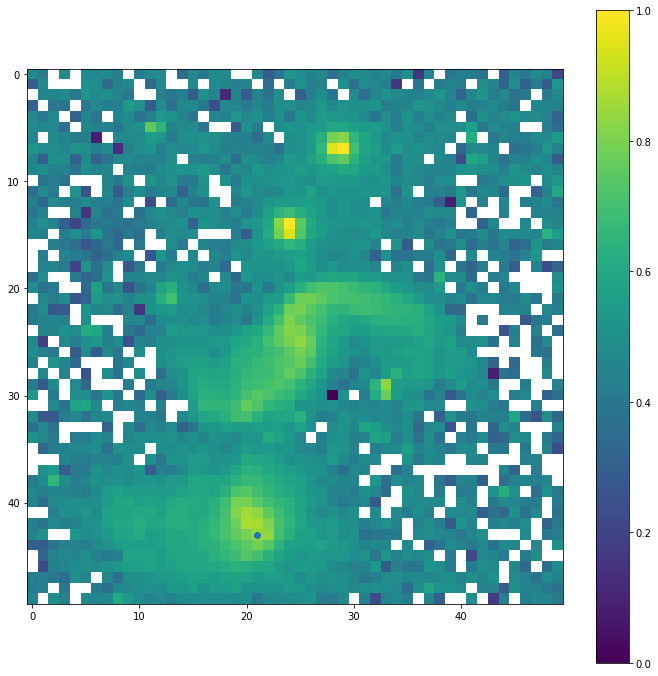

In [18]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(obs_image))
plt.scatter(y,x)
plt.colorbar()
plt.show()

## Converting Pixels to Physical Space

In [19]:
redshifts = pd.read_csv(f'{folder}/APySPAM_MCMC/Redshifts/Redshifts.csv', index_col = 0)

In [57]:
row = redshifts.query('Names == @galaxy')
block_reduce = row.block_reduce.iloc[0]
z = row.Redshift

In [71]:
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.275 * u.K, Om0 = 0.308)
d = np.float64(cosmo.luminosity_distance(z)) * 1e3
Resolution = np.float64(cosmo.kpc_proper_per_arcmin(z)) * (0.396 / 60) * u.arcmin * block_reduce

In [72]:
x_kpc = (x - 25) * Resolution
x_kpc

<Quantity [32.27944463] kpc>

In [74]:
x_sim = x_kpc / (15 * u.kpc)
x_sim

<Quantity [2.15196298]>

In [49]:
y_kpc = (y - 25) * Resolution
y_kpc

4   -7.17321
Name: block_reduce, dtype: float64

In [50]:
y_sim = y_kpc / 15
y_sim

4   -0.478214
Name: block_reduce, dtype: float64

## Creating the Corner Plot

In [29]:
corner_plot_values = (likelihood_dist)**-1

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.


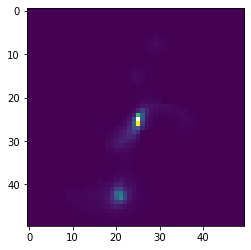

In [31]:
plt.figure()
plt.imshow(corner_plot_values.T)

In [88]:
x_list_pix = np.arange(0,50)
y_list_pix = np.arange(0,50)